In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip3 install torch torchvision pandas transformers scikit-learn tensorflow numpy seaborn matplotlib textwrap3

In [4]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [9]:
import transformers
from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup
import torch
from torchvision import transforms
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image


def clean_text(text):
    text = re.sub(r"@[A-Za-z0-9_]+", ' ', text)
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
    text = re.sub(r"[^a-zA-z.,!?'0-9]", ' ', text)
    text = re.sub('\t', ' ',  text)
    text = re.sub(r" +", ' ', text)
    return text

def label_to_target(text):
  if text == "informative":
    return 1
  else:
    return 0

df_train = pd.read_csv("./gdrive/MyDrive/ColabNotebooks/train.tsv", sep='\t')
df_train = df_train[['image', 'tweet_text', 'label_text']]
df_train = df_train.sample(frac=1, random_state = 24).reset_index(drop=True)
df_train['tweet_text'] = df_train['tweet_text'].apply(clean_text)
df_train['label_text'] = df_train['label_text'].apply(label_to_target)

df_val = pd.read_csv("./gdrive/MyDrive/ColabNotebooks/val.tsv", sep='\t')
df_val = df_val[['image', 'tweet_text', 'label_text']]
df_val = df_val.sample(frac=1, random_state = 24).reset_index(drop=True)
df_val['tweet_text'] = df_val['tweet_text'].apply(clean_text)
df_val['label_text'] = df_val['label_text'].apply(label_to_target)

df_test = pd.read_csv("./gdrive/MyDrive/ColabNotebooks/test.tsv", sep='\t')
df_test = df_test[['image', 'tweet_text', 'label_text']]
df_test = df_test.sample(frac=1, random_state = 24).reset_index(drop=True)
df_test['tweet_text'] = df_test['tweet_text'].apply(clean_text)
df_test['label_text'] = df_test['label_text'].apply(label_to_target)


In [13]:
data_dir = "./gdrive/MyDrive/"
class DisasterTweetDataset(Dataset):

  def __init__(self, tweets, targets, paths, tokenizer, max_len):
    self.tweets = tweets
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
    self.paths = paths
    self.transform = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
  
  def __len__(self):
    return len(self.tweets)
  
  def __getitem__(self, item):
    tweet = str(self.tweets[item])
    target = self.targets[item]
    path = str(self.paths[item])
    img = Image.open(data_dir+self.paths[item]).convert('RGB')
    img = self.transform(img)  

    encoding = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation = True
    )

    return {
      'tweet_text': tweet,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long),
      'tweet_image': img
    }

def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = DisasterTweetDataset(
    tweets=df.tweet_text.to_numpy(),
    targets=df.label_text.to_numpy(),
    paths=df.image.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )


class TweetClassifier(nn.Module):

  def __init__(self):
    super(TweetClassifier, self).__init__()
    self.roberta = RobertaModel.from_pretrained("roberta-base")
    for param in self.roberta.parameters():
      param.requires_grad = False
    
    self.resnet = torchvision.models.resnet18(pretrained=True)
    for param in self.resnet.parameters():
      param.requires_grad = False
    
    self.bn = nn.BatchNorm1d(self.roberta.config.hidden_size + 1000)

    self.linear1 = nn.Linear(self.roberta.config.hidden_size + 1000, 1000)
    self.relu1    = nn.ReLU()
    self.dropout1 = nn.Dropout(p=0.4)

    self.linear2 = nn.Linear(1000, 500)
    self.relu2    = nn.ReLU()
    self.dropout2 = nn.Dropout(p=0.2)

    self.linear3 = nn.Linear(500, 250)
    self.relu3    = nn.ReLU()
    self.dropout3 = nn.Dropout(p=0.1)

    self.linear4 = nn.Linear(250, 125)
    self.relu4    = nn.ReLU()
    self.dropout4 = nn.Dropout(p=0.02)

    self.linear5 = nn.Linear(125, 1)
    self.sigmoid = nn.Sigmoid()
  
  def forward(self, input_ids, attention_mask, tweet_img):
    output = self.roberta(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = output[0]
    text_output = torch.mean(output, 1)

    image_output = self.resnet(tweet_img)
    merged_output = torch.cat((text_output, image_output), dim=1)
    bn_output = self.bn(merged_output)

    linear1_output = self.linear1(bn_output)
    relu1_output = self.relu1(linear1_output)
    dropout1_output = self.dropout1(relu1_output)

    linear2_output = self.linear2(dropout1_output)
    relu2_output = self.relu2(linear2_output)
    dropout2_output = self.dropout2(relu2_output)

    linear3_output = self.linear3(dropout2_output)
    relu3_output = self.relu3(linear3_output)
    dropout3_output = self.dropout3(relu3_output)

    linear4_output = self.linear4(dropout3_output)
    relu4_output = self.relu4(linear4_output)
    dropout4_output = self.dropout4(relu4_output)

    linear5_output = self.linear5(dropout4_output)


    probas = self.sigmoid(linear5_output)
    return probas


def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    tweet_imgs = d["tweet_image"].to(device)
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].reshape(-1, 1).float()
    targets = targets.to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      tweet_img = tweet_imgs
    )


    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(torch.round(outputs) == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      tweet_imgs = d["tweet_image"].to(device)
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].reshape(-1, 1).float()
      targets = targets.to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        tweet_img = tweet_imgs
      )

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(torch.round(outputs) == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [14]:
BATCH_SIZE = 512
MAX_LEN = 150

PRE_TRAINED_MODEL_NAME = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


model = TweetClassifier()
model = model.to(device)

EPOCHS = 50

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.BCELoss().to(device)

In [15]:
history = defaultdict(list)
start_epoch = 0
best_accuracy = -1

# checkpoint = torch.load("./gdrive/MyDrive/Models/RobertaResnet/checkpoint.t7")
# model.load_state_dict(checkpoint['state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer'])
# start_epoch = checkpoint['epoch']
# best_accuracy = checkpoint['best_accuracy']

# print(start_epoch)
# print(best_accuracy)


for epoch in range(EPOCHS):

  print(f'Epoch {start_epoch + epoch + 1}/{start_epoch + EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    state = {
            'best_accuracy': val_acc,
            'epoch': start_epoch+epoch+1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
    }
    savepath= "./gdrive/MyDrive/Models/RobertaResnet/checkpoint.t7"
    torch.save(state,savepath)
    best_accuracy = val_acc

Epoch 1/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.6353140316511455 accuracy 0.6450369753150713
Val   loss 0.5338080823421478 accuracy 0.7666878575969485

Epoch 2/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.43062655863009003 accuracy 0.8242891365482762
Val   loss 0.40450168401002884 accuracy 0.8264462809917356

Epoch 3/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.32168271510224594 accuracy 0.8655348401208207
Val   loss 0.34296662360429764 accuracy 0.8531468531468531

Epoch 4/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.2937098082743193 accuracy 0.8794917196125404
Val   loss 0.332816444337368 accuracy 0.8658614113159567

Epoch 5/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.276086153952699 accuracy 0.8856369128215811
Val   loss 0.32787927240133286 accuracy 0.8690400508582327

Epoch 6/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.2605864852666855 accuracy 0.892927820018748
Val   loss 0.3270678445696831 accuracy 0.8696757787666879

Epoch 7/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.25211467476267563 accuracy 0.8994896364961983
Val   loss 0.3239610269665718 accuracy 0.8696757787666879

Epoch 8/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.24010311537667325 accuracy 0.9057389855223414
Val   loss 0.3232276290655136 accuracy 0.866497139224412

Epoch 9/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.23243775101084457 accuracy 0.90480158316842
Val   loss 0.32031404972076416 accuracy 0.8734901462174189

Epoch 10/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.2266697750279778 accuracy 0.9082387251327987
Val   loss 0.3198064789175987 accuracy 0.8722186904005086

Epoch 11/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.22044223390127482 accuracy 0.9094885949380273
Val   loss 0.3161826357245445 accuracy 0.8773045136681501

Epoch 12/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.20729040864266848 accuracy 0.9171961254036037
Val   loss 0.3164157047867775 accuracy 0.8785759694850604

Epoch 13/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.20360263319391952 accuracy 0.9190709301114467
Val   loss 0.31610287725925446 accuracy 0.8766687857596949

Epoch 14/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.19803974895100845 accuracy 0.9213623580876992
Val   loss 0.31805650889873505 accuracy 0.8766687857596949

Epoch 15/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.18737279349251798 accuracy 0.9283407978335589
Val   loss 0.32324177771806717 accuracy 0.8760330578512396

Epoch 16/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.18241065740585327 accuracy 0.9294865118216852
Val   loss 0.32715389132499695 accuracy 0.8773045136681501

Epoch 17/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.18079298107247604 accuracy 0.9296948234558899
Val   loss 0.3308350369334221 accuracy 0.8753973299427845

Epoch 18/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.1710340341455058 accuracy 0.9324028747005519
Val   loss 0.32503893226385117 accuracy 0.8792116973935156

Epoch 19/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.17097504829105578 accuracy 0.9336527445057806
Val   loss 0.328211672604084 accuracy 0.8817546090273363

Epoch 20/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.16857987250152387 accuracy 0.935110925945214
Val   loss 0.3308943435549736 accuracy 0.8836617927527018

Epoch 21/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.16292155651669754 accuracy 0.9381314446411831
Val   loss 0.3331202119588852 accuracy 0.8811188811188811

Epoch 22/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.15636886577857168 accuracy 0.9417768982397666
Val   loss 0.3325972929596901 accuracy 0.8798474253019708

Epoch 23/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.16005061253121025 accuracy 0.9379231330069784
Val   loss 0.33744387328624725 accuracy 0.8804831532104259

Epoch 24/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.15231133605304517 accuracy 0.9425059889594833
Val   loss 0.33648625016212463 accuracy 0.8811188811188811

Epoch 25/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.14943859843831314 accuracy 0.9450057285699406
Val   loss 0.34533190727233887 accuracy 0.8779402415766052

Epoch 26/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.1477040530819642 accuracy 0.9444849494844286
Val   loss 0.341494545340538 accuracy 0.8779402415766052

Epoch 27/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.14508583279032455 accuracy 0.9443807936673263
Val   loss 0.34359245747327805 accuracy 0.8773045136681501

Epoch 28/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.14334977653465772 accuracy 0.9467763774606811
Val   loss 0.34412481635808945 accuracy 0.8785759694850604

Epoch 29/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.14520563028360667 accuracy 0.9454223518383501
Val   loss 0.3492042198777199 accuracy 0.8785759694850604

Epoch 30/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.14245768675678655 accuracy 0.9458389751067596
Val   loss 0.34950166940689087 accuracy 0.8773045136681501

Epoch 31/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.13419236164343984 accuracy 0.9500052077908551
Val   loss 0.3500268906354904 accuracy 0.8760330578512396

Epoch 32/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.13798390093602633 accuracy 0.9474013123632955
Val   loss 0.35548894107341766 accuracy 0.8766687857596949

Epoch 33/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.13245150486105367 accuracy 0.9528174148526195
Val   loss 0.3523405119776726 accuracy 0.8779402415766052

Epoch 34/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.12788357428814234 accuracy 0.9535465055723362
Val   loss 0.3555808663368225 accuracy 0.8766687857596949

Epoch 35/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.127068498024815 accuracy 0.951880012498698
Val   loss 0.35687315464019775 accuracy 0.8773045136681501

Epoch 36/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.12727702644310498 accuracy 0.9534423497552338
Val   loss 0.3574373126029968 accuracy 0.8741258741258742

Epoch 37/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.1303869756428819 accuracy 0.9504218310592646
Val   loss 0.35729093849658966 accuracy 0.8760330578512396

Epoch 38/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.1251710112157621 accuracy 0.956462868451203
Val   loss 0.3586648851633072 accuracy 0.8779402415766052

Epoch 39/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.12181850365902248 accuracy 0.9554213102801791
Val   loss 0.3580900654196739 accuracy 0.8773045136681501

Epoch 40/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.12508444723330045 accuracy 0.9543797521091553
Val   loss 0.36015498638153076 accuracy 0.8779402415766052

Epoch 41/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.12358816909162622 accuracy 0.9543797521091553
Val   loss 0.3609066978096962 accuracy 0.8766687857596949

Epoch 42/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.12286767089053204 accuracy 0.9539631288407457
Val   loss 0.36090368777513504 accuracy 0.8760330578512396

Epoch 43/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.12233573825735795 accuracy 0.9534423497552338
Val   loss 0.3621545433998108 accuracy 0.8760330578512396

Epoch 44/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.11844136761991601 accuracy 0.9543797521091553
Val   loss 0.3626067340373993 accuracy 0.8753973299427845

Epoch 45/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.12335592665170368 accuracy 0.9542755962920528
Val   loss 0.36238018423318863 accuracy 0.8753973299427845

Epoch 46/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.11989251641850722 accuracy 0.9562545568169982
Val   loss 0.3620775565505028 accuracy 0.8760330578512396

Epoch 47/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.11813460290431976 accuracy 0.9582335173419435
Val   loss 0.3623308390378952 accuracy 0.8753973299427845

Epoch 48/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.12027037888765335 accuracy 0.9555254660972815
Val   loss 0.3630760461091995 accuracy 0.8747616020343293

Epoch 49/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.12270111237701617 accuracy 0.95458806374336
Val   loss 0.3625488132238388 accuracy 0.8747616020343293

Epoch 50/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.11640871865184683 accuracy 0.957816894073534
Val   loss 0.3635126128792763 accuracy 0.8747616020343293



In [16]:
state = {
        'epoch': start_epoch + EPOCHS,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
}
savepath= "./gdrive/MyDrive/Models/RobertaResnet/checkpoint-{}.t7".format(start_epoch + EPOCHS)
torch.save(state,savepath)

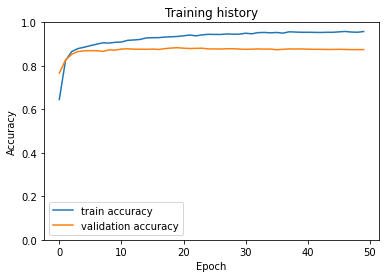

In [17]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [18]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  predictions = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      input_ids = d["input_ids"].to(device)
      tweet_imgs = d["tweet_image"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].reshape(-1, 1).float()
      targets = targets.to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        tweet_img = tweet_imgs
      )
      preds = torch.round(outputs)


      predictions.extend(preds)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, real_values

y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

print(classification_report(y_test, y_pred, target_names=['Not Informative', 'Informative'], digits=4))

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


                 precision    recall  f1-score   support

Not Informative     0.8949    0.7599    0.8219       504
    Informative     0.8906    0.9563    0.9223      1030

       accuracy                         0.8918      1534
      macro avg     0.8927    0.8581    0.8721      1534
   weighted avg     0.8920    0.8918    0.8893      1534

